In [1]:
#import necessary libraries
# data science
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func


# Reflect Tables into SQLAlchemy ORM

In [2]:
 # Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)


C:\Users\fatin\AppData\Local\Temp\ipykernel_16416\1439740260.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [3]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [4]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [5]:
# Precipitation Analysis
# Find the most recent date in the dataset
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
if most_recent_date:
    most_recent_date = most_recent_date[0]
    print(f"Most recent date in the dataset: {most_recent_date}")
else:
    print("No data found in the dataset.")
    # Close the session and exit
    session.close()
    exit()

Most recent date in the dataset: 2017-08-23


In [6]:
# Convert the most recent date to datetime
most_recent_date = pd.to_datetime(most_recent_date)
one_year_ago = most_recent_date - pd.DateOffset(years=1)
print(f"One year ago from the most recent date: {one_year_ago}")

One year ago from the most recent date: 2016-08-23 00:00:00


In [23]:
# Get the previous 12 months of precipitation data
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

In [24]:
# Load the query results into a Pandas DataFrame
precip_df = pd.DataFrame(precip_data, columns=["date", "prcp"])

In [25]:
# Sort the DataFrame values by "date"
precip_df = precip_df.sort_values("date")

print(...)

Ellipsis


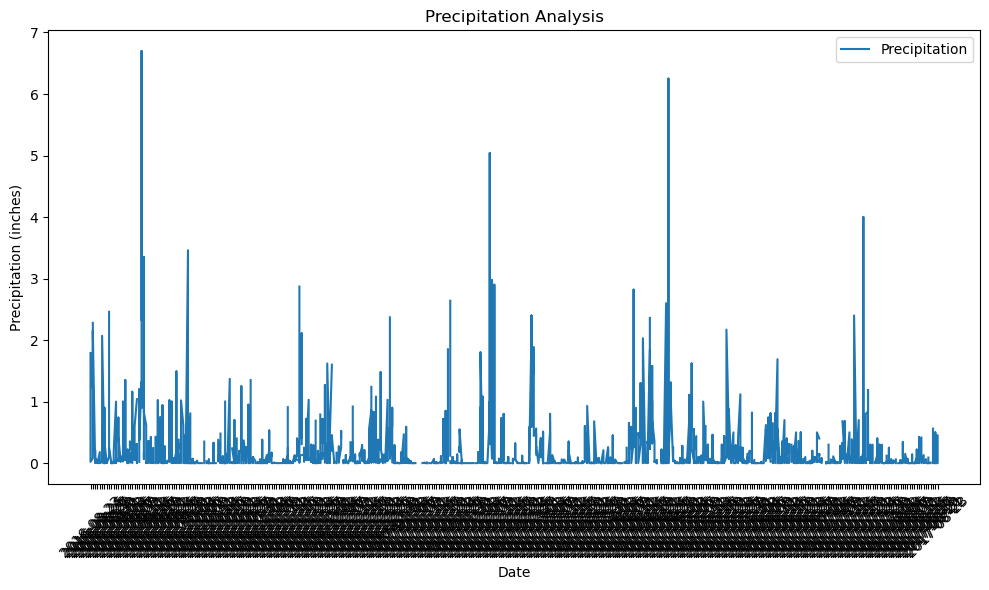

In [26]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(precip_df["date"], precip_df["prcp"], label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Analysis")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Use Pandas to print the summary statistics for the precipitation data
print(precip_df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [ ]:
 Exploratory Station Analysis

In [28]:
# Calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [30]:
# Find the most-active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

# List the stations and observation counts in descending order
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

Most active stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [31]:
# Identify the station with the greatest number of observations
most_active_station = active_stations[0][0]
print(f"Station with the greatest number of observations: {most_active_station}")

Station with the greatest number of observations: USC00519281


In [32]:
# Calculate the lowest, highest, and average temperatures for the most active station
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

print(f"Temperature stats for the most active station ({most_active_station}):")
print(f"Lowest temperature: {temp_stats[0][0]}")
print(f"Highest temperature: {temp_stats[0][1]}")
print(f"Average temperature: {temp_stats[0][2]}")

Temperature stats for the most active station (USC00519281):
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


In [34]:
# Get the previous 12 months of temperature observation (TOBS) data
tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).all()

# Load the query results into a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])


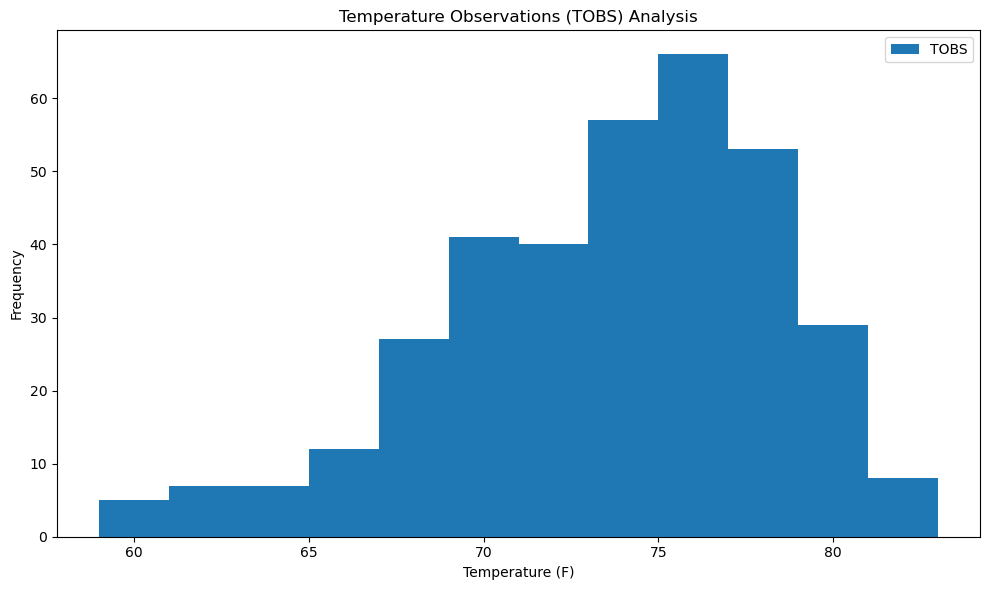

In [35]:
# Plot the results as a histogram with bins=12
plt.figure(figsize=(10, 6))
plt.hist(tobs_df["tobs"], bins=12, label="TOBS")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations (TOBS) Analysis")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Station Analysis
# Calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [15]:
# Find the most-active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

# List the stations and observation counts in descending order
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")


Most active stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [4]:
# Get the previous 12 months of precipitation data
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


NameError: name 'most_recent_date' is not defined

In [3]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base

print(list(Base.classes)) 

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [5]:
Measurement = Base.classes.measurement
Station = Base.classes.station


In [6]:
session = Session(engine)

recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)  # Output the most recent date for verification


2017-08-23


In [7]:
session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23',)]

In [8]:
query = """
    SELECT
        date,
        station,
        prcp
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
    ORDER BY
        date ASC;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


In [9]:
start_date = datetime(2016, 8, 23).date()


TypeError: 'module' object is not callable

In [ ]:
# Calculate the date one year from the last date in data set.
start_date = datetime(2016, 8, 23).date()


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])

# Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df2.head()

In [ ]:
# Example of defining precipitation_data
precipitation_data = [
    {'date': '2024-01-01', 'prcp': 0.5},
    {'date': '2024-01-02', 'prcp': 0.7},
    # Add more data as needed
]

# Now you can create the DataFrame without encountering a NameError
df_precipitation = pd.DataFrame(precipitation_data, columns=["date", "prcp"])
df_precipitation = pd.DataFrame(precipitation_data, columns=["date", "prcp"])


In [ ]:
df_precipitation = df_precipitation.sort_values("date")


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df2.Date, df2.Precipitation)
plt.show()

In [ ]:
df_precipitation.plot(x="date", y="prcp", figsize=(10, 6), title="Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

df2.Precipitation.describe()

In [ ]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

In [ ]:
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


In [ ]:
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
print(active_stations)


In [ ]:
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")


In [ ]:
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Temperature stats for station {most_active_station}: {temperature_stats}")


In [ ]:
# If the last date in your dataset is '2017-08-23'
last_date = datetime(2017, 8, 23)

# Calculate 'one_year_ago' from 'last_date'
one_year_ago = last_date - timedelta(days=365)


In [ ]:
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()


In [ ]:
df_tobs = pd.DataFrame(tobs_data, columns=["date", "tobs"])

df_tobs["tobs"].plot(kind="hist", bins=12, figsize=(10, 6), title="Temperature Observations for Station " + most_active_station)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [36]:
# Close Session
session.close()
